Mitigate selection bias and self selection bias

Propensity score matching: create a counterfactual group with similar characteristics to your treatment group

Context: in the 1970s, the National Support Work Demonstration held training programs for disadvanged workers. How do we measure the impact?


Setup

In [8]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.api import Logit, add_constant
from causalml.match import NearestNeighborMatch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
df = pd.read_csv("/content/lalonde.csv")

In [10]:
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [11]:
# Summary Statistics
df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [19]:
# create the dependent variable re78-75
df['re78-re75']= df['re78']-df['re75']
df['y']= df['re78']-df['re75']

In [8]:
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,re78-re75
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,9930.0460
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,3595.8940
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,24909.4500
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,7506.1460
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,289.7899


In [14]:
df.groupby('treat').mean()

,age,educ,black,hispan,married,nodegree,re74,re75,re78,re78-re75
treat,,,,,,,,,,
0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742,4517.685299
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,4817.088216


In [15]:
continuous_confounders = ["age","educ","re74"]
t_test_result = {}
for confounder in continuous_confounders:
  control_group = df[df['treat']==0][confounder]
  treatment_group = df[df['treat']==1][confounder]
  # calculate the t test for the means of two independent sample of scores
  t_test_result[confounder] = stats.ttest_ind(control_group, treatment_group)
t_test_result

{'age': TtestResult(statistic=np.float64(2.5590130633091523), pvalue=np.float64(0.010736332582438224), df=np.float64(612.0)),
 'educ': TtestResult(statistic=np.float64(-0.47774686042840225), pvalue=np.float64(0.6330009720473465), df=np.float64(612.0)),
 're74': TtestResult(statistic=np.float64(6.381464485508746), pvalue=np.float64(3.464585257757616e-10), df=np.float64(612.0))}

In [18]:
t_test_df = pd.DataFrame.from_dict(t_test_result
                         , orient='index'
                         ,columns=['t-stats','p-value'])
print(t_test_df.to_string(float_format='{:.4f}'.format))
# there are differences in education. no differences in age or income in pre-period

      t-stats  p-value
age    2.5590   0.0107
educ  -0.4777   0.6330
re74   6.3815   0.0000


In [22]:
# Common Support Region
# Logistic Regression for the Propensity Scores
# Isolate the treat and the confounders
treat = df.treat
confounders = df.drop(columns=['treat','re75','re78','re78-re75','y'])

In [23]:
confounders.head()

,age,educ,black,hispan,married,nodegree,re74
0,37,11,1,0,1,1,0.0
1,22,9,0,1,0,1,0.0
2,30,12,1,0,0,0,0.0
3,27,11,1,0,0,1,0.0
4,33,8,1,0,0,1,0.0


In [24]:
model = Logit(treat, add_constant(confounders)).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.398371
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                            7
Date:                Sun, 14 Sep 2025   Pseudo R-squ.:                  0.3490
Time:                        02:30:03   Log-Likelihood:                -244.60
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 6.683e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7243      1.020     -4.632      0.000      -6.723      -2.725
age            0.0148      0.

In [26]:
# Compute the propensity scores
df['propensity_score'] = model.predict(add_constant(confounders))
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,re78-re75,y,propensity_score
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,9930.0460,9930.0460,0.660351
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,3595.8940,3595.8940,0.233772
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,24909.4500,24909.4500,0.679642
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,7506.1460,7506.1460,0.781604
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,289.7899,289.7899,0.705896


In [27]:
# Data Visualization
# isolate propensity and treat
df_csr = df[['propensity_score','treat']]
df_csr.head()


,propensity_score,treat
0,0.660351,1
1,0.233772,1
2,0.679642,1
3,0.781604,1
4,0.705896,1


In [30]:
# separate propensity scores by treatment group
non_treated_scores = df[df['treat']==0]['propensity_score']
treated_scores = df[df['treat']==1]['propensity_score']

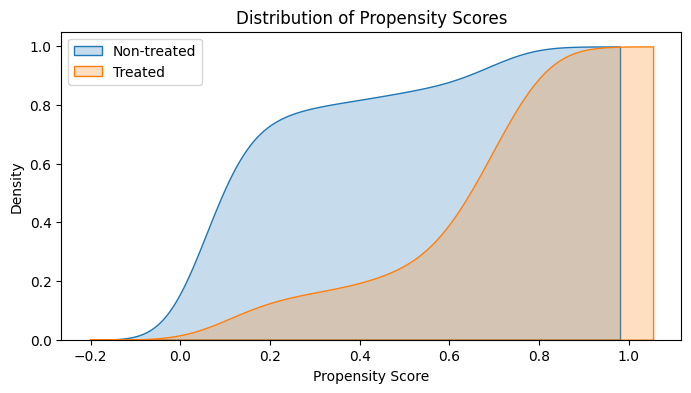

In [34]:
# plot the distribution of the propensity scores with kde plot
plt.figure(figsize=(8,4))
sns.kdeplot(non_treated_scores, label='Non-treated', fill=True, cumulative=True)
sns.kdeplot(treated_scores, label='Treated', fill=True, cumulative=True)
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

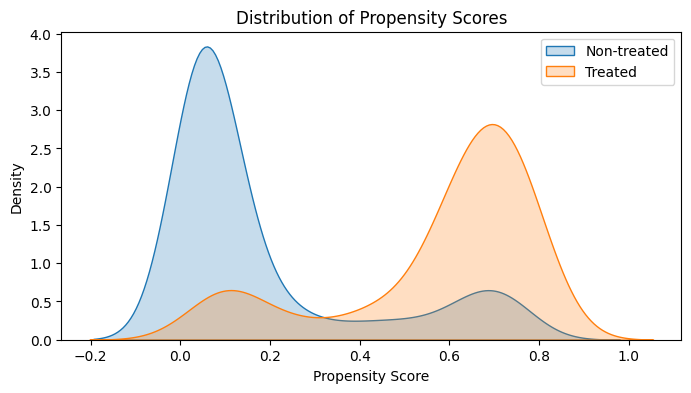

In [35]:
# plot the distribution of the propensity scores with kde plot
plt.figure(figsize=(8,4))
sns.kdeplot(non_treated_scores, label='Non-treated', fill=True)
sns.kdeplot(treated_scores, label='Treated', fill=True)
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

The control group should be 4 or 5 times the treatment group. The two groups are too different.

Propensity Score Matching

In [52]:
confounders_list = confounders.columns.to_list()
confounders_list +=['propensity_score']

In [54]:
confounders_list

['age',
 'educ',
 'black',
 'hispan',
 'married',
 'nodegree',
 're74',
 'propensity_score']

In [55]:
# Initiate the matcher
matcher = NearestNeighborMatch(caliper = 0.2,
                               replace = True,
                               ratio = 2,
                               shuffle = True)
matched_data = matcher.match(data=df
                             , treatment_col='treat'
                             , score_cols=confounders_list)
matched_data.head() # non-matched data is gone

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,re78-re75,y,propensity_score
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,9930.0460,9930.0460,0.660351
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,3595.8940,3595.8940,0.233772
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,24909.4500,24909.4500,0.679642
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,7506.1460,7506.1460,0.781604
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,289.7899,289.7899,0.705896


In [56]:
# Create a report on the matched data
from causalml.match import create_table_one
create_table_one(
    data = matched_data,
    treatment_col = 'treat',
    features = confounders_list
)

,Control,Treatment,SMD
Variable,,,
n,223,128,
age,22.50 (6.21),24.01 (6.31),0.2412
black,0.83 (0.37),0.84 (0.36),0.0262
educ,10.45 (1.73),10.48 (1.83),0.0158
hispan,0.05 (0.23),0.05 (0.23),0.0039
married,0.10 (0.30),0.09 (0.29),-0.0166
nodegree,0.65 (0.48),0.67 (0.47),0.0362
propensity_score,0.58 (0.23),0.60 (0.23),0.0581
re74,1252.91 (2812.56),1246.81 (2892.61),-0.0021


In [51]:
matched_data.treat.value_counts()

,count
treat,
0,221
1,126


In [57]:
# compare the income evolution from 75 to 78
matched_data.groupby('treat').mean()

,age,educ,black,hispan,married,nodegree,re74,re75,re78,re78-re75,y,propensity_score
treat,,,,,,,,,,,,
0,22.497758,10.448430,0.834081,0.053812,0.098655,0.654709,1252.911589,1206.773698,4864.158970,3657.385272,3657.385272,0.584964
1,24.007812,10.476562,0.843750,0.054688,0.093750,0.671875,1246.813256,1144.348180,6080.863337,4936.515157,4936.515157,0.598198


* Only ~66^ of the treated group was matched
*   Among the matched samples, we observed 1.2K more income increasewithin the treatment group

